In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
dataset = pd.read_csv('Credit_Card_Applications.csv')
X = dataset.iloc[:, :-1].values 
y = dataset.iloc[:, -1].values

In [3]:
# SOM to identify current fradulent clients

# Feature scaling 
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
X = sc.fit_transform(X)

In [4]:
# Training SOM
from minisom import MiniSom
som = MiniSom(x=10, y=10, input_len= 15, sigma= 1.0, learning_rate = 0.5)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 100)

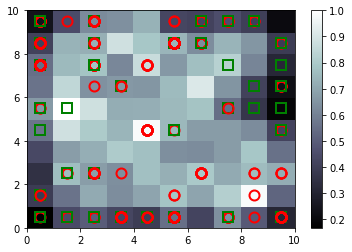

In [8]:
# Visualize SOM
from pylab import bone, pcolor, colorbar, plot, show
bone()
# Getting MID (mean intermediate distance between all the nodes and the BMU within the neighborhood defined by sigma), higher(whiter) == further away from neighbors == more it is an outlier == fraud
pcolor(som.distance_map().T)
colorbar()

# Distinguishing between customers who got approval while fradulent and those who did not (is more relevant to attack fraud that is within the company now, than those that got rejected)
# Red circle == not approved, green square == approved
markers = ['o', 's']
colors = ['r', 'g']
for i,x in enumerate(X):
    w = som.winner(x)
#     Centering marker
    plot(w[0] + 0.5, w[1] + 0.5, markers[y[i]], markeredgecolor = colors[y[i]], markerfacecolor = 'None', markersize = 10, markeredgewidth = 2)

show()

In [10]:
# Getting list of fradulent clients (those in white clusters) using their coordinates
mappings = som.win_map(X)
frauds = np.concatenate((mappings[(4,4)], mappings[(8,2)]), axis = 0)
frauds = np.concatenate((frauds, mappings[(1,5)]), axis = 0)
frauds = sc.inverse_transform(frauds)

In [11]:
# ANN to rank the clients by probaibility of fradulent activity

# Creating matrix of features using original dataset (remember that id is not relevant)
clients = dataset.iloc[:, 1:].values 

# Creating dependent variable (Check if customer from list is in fraud list and then say that 0 no fraud, 1 is fraud)
is_fraud = np.zeros(len(dataset))
for i in range(len(dataset)):
    if dataset.iloc[i,0] in frauds:
        is_fraud[i] = 1

In [12]:
# Train ANN

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# For deeplearning we must scale all the features
clients = sc.fit_transform(clients)

# Building the ANN
from keras.models import Sequential
from keras.layers import Dense
# Initializing it
classifier = Sequential()

# Adding input layer
classifier.add(Dense(units=2,kernel_initializer = 'uniform', activation='relu', input_dim = 15))

# Adding output layer
classifier.add(Dense(units=1,kernel_initializer = 'uniform', activation='sigmoid'))

# Training ANN (adam uses stochastic descent)
classifier.compile(optimizer='adam', loss= 'binary_crossentropy', metrics= ['accuracy'])
classifier.fit(clients,is_fraud,batch_size=1,epochs=2)

Epoch 1/2
690/690 [==============================] - 2s 3ms/step - loss: 0.4568 - accuracy: 0.9739: 0s - loss: 0.4734 - accuracy: 
Epoch 2/2
690/690 [==============================] - 2s 3ms/step - loss: 0.2079 - accuracy: 0.9739


In [15]:
#  Make prediction (probabilities of fraud)
y_pred = classifier.predict(clients)
# Using this sintaxis as dataset is a 2D array but only need id
y_pred = np.concatenate((dataset.iloc[:,0 : 1].values, y_pred), axis = 1)

In [16]:
print(y_pred)

[[1.57761560e+07 3.45414579e-02]
 [1.57395480e+07 4.60689068e-02]
 [1.56628540e+07 3.34056914e-02]
 ...
 [1.56754500e+07 5.52454591e-02]
 [1.57764940e+07 1.75040513e-01]
 [1.55924120e+07 6.00260720e-02]]


In [20]:
# Rank predictions by sorting them based on their probabilities (from lowest to greatest)
y_pred = y_pred[y_pred[:, 1].argsort()]

In [19]:
print(y_pred)

[[1.55991520e+07 7.41446018e-03]
 [1.56009750e+07 7.99959898e-03]
 [1.57114460e+07 8.58187675e-03]
 ...
 [1.55715710e+07 3.14351082e-01]
 [1.56647930e+07 3.14351082e-01]
 [1.58098370e+07 3.14351082e-01]]
